In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
import pandas as pd

2023-01-12 21:14:33.527504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 21:14:33.768978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 21:14:33.769005: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 21:14:34.489761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

https://cloud.tencent.com/developer/article/1451545

In [2]:
dataset = pd.read_csv("../wind_preprocessed.csv", header=0, index_col=0).query('day<14')

In [3]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [4]:
ddf = data[['power']]
ddf.head()

,power
date,
2015-10-01 00:00:00,0.38065
2015-10-01 00:00:30,0.36943
2015-10-01 00:01:00,0.38529
2015-10-01 00:01:30,0.38892
2015-10-01 00:02:00,0.41220


In [5]:
dddf_train = ddf.iloc[:3*2880]
dddf_train.head()

,power
date,
2015-10-01 00:00:00,0.38065
2015-10-01 00:00:30,0.36943
2015-10-01 00:01:00,0.38529
2015-10-01 00:01:30,0.38892
2015-10-01 00:02:00,0.41220


In [6]:
ddddf= []
for i in range(len(dddf_train)):
    ddddf.append(dddf_train.iloc[i,0])
ddddf

[0.38065,
 0.36943,
 0.38529,
 0.38892,
 0.4122,
 0.42277,
 0.40035,
 0.41485,
 0.41225,
 0.4024,
 0.39804,
 0.37576,
 0.39463,
 0.41636,
 0.41607,
 0.41616,
 0.40367,
 0.40117,
 0.39506,
 0.38497,
 0.39617,
 0.38003,
 0.39509,
 0.4133,
 0.42121,
 0.40457,
 0.3977,
 0.39169,
 0.42498,
 0.41577,
 0.40779,
 0.40262,
 0.3841,
 0.38777,
 0.3852,
 0.38359,
 0.37297,
 0.39178,
 0.39492,
 0.3902,
 0.39344,
 0.40677,
 0.40028,
 0.39906,
 0.37767,
 0.37376,
 0.37285,
 0.3872,
 0.36578,
 0.36333,
 0.36873,
 0.37599,
 0.38515,
 0.35806,
 0.37292,
 0.35059,
 0.35292,
 0.34622,
 0.3474,
 0.34181,
 0.35037,
 0.3378,
 0.3579,
 0.36732,
 0.37082,
 0.35184,
 0.36148,
 0.38594,
 0.38233,
 0.37403,
 0.3797,
 0.38682,
 0.36351,
 0.33953,
 0.34087,
 0.33675,
 0.34821,
 0.3573,
 0.35299,
 0.36989,
 0.38059,
 0.39519,
 0.3963,
 0.40038,
 0.39087,
 0.38642,
 0.39597,
 0.40579,
 0.39248,
 0.39151,
 0.38545,
 0.39444,
 0.40343,
 0.40777,
 0.42031,
 0.42415,
 0.41184,
 0.41687,
 0.40966,
 0.38686,
 0.38019,
 0.4

In [7]:
def split_sequence(sequence, sw_width, n_features):
    '''
    这个简单的示例，通过for循环实现有重叠截取数据，滑动步长为1，滑动窗口宽度为sw_width。
    
    '''
    X, y = [], []
    
    for i in range(len(sequence)):
        # 获取单个样本中最后一个元素的索引，因为python切片前闭后开，索引从0开始，所以不需要-1
        end_element_index = i + sw_width
        # 如果样本最后一个元素的索引超过了序列索引的最大长度，说明不满足样本元素个数，则这个样本丢弃
        if end_element_index > len(sequence) - 1:
            break
        # 通过切片实现步长为1的滑动窗口截取数据组成样本的效果
        seq_x, seq_y = sequence[i:end_element_index], sequence[end_element_index]
        
        X.append(seq_x)
        y.append(seq_y)
        
        process_X, process_y = np.array(X), np.array(y)
        process_X = process_X.reshape((process_X.shape[0], process_X.shape[1], n_features))
    
    print('split_sequence:\nX:\n{}\ny:\n{}\n'.format(np.array(X), np.array(y)))
    print('X_shape:{},y_shape:{}\n'.format(np.array(X).shape, np.array(y).shape))
    print('train_X:\n{}\ntrain_y:\n{}\n'.format(process_X, process_y))
    print('train_X.shape:{},trian_y.shape:{}\n'.format(process_X.shape, process_y.shape))
    return process_X, process_y


In [8]:
sw_width = 30
n_features = 1
epoch_num = 50
verbose_set = 1

In [9]:
train_X, train_y = split_sequence(ddddf, sw_width, n_features)

split_sequence:
X:
[[0.38065 0.36943 0.38529 ... 0.39169 0.42498 0.41577]
 [0.36943 0.38529 0.38892 ... 0.42498 0.41577 0.40779]
 [0.38529 0.38892 0.4122  ... 0.41577 0.40779 0.40262]
 ...
 [0.52893 0.51593 0.52808 ... 0.45952 0.45011 0.4565 ]
 [0.51593 0.52808 0.53433 ... 0.45011 0.4565  0.46646]
 [0.52808 0.53433 0.51624 ... 0.4565  0.46646 0.45001]]
y:
[0.40779 0.40262 0.3841  ... 0.46646 0.45001 0.43612]

X_shape:(8610, 30),y_shape:(8610,)

train_X:
[[[0.38065]
  [0.36943]
  [0.38529]
  ...
  [0.39169]
  [0.42498]
  [0.41577]]

 [[0.36943]
  [0.38529]
  [0.38892]
  ...
  [0.42498]
  [0.41577]
  [0.40779]]

 [[0.38529]
  [0.38892]
  [0.4122 ]
  ...
  [0.41577]
  [0.40779]
  [0.40262]]

 ...

 [[0.52893]
  [0.51593]
  [0.52808]
  ...
  [0.45952]
  [0.45011]
  [0.4565 ]]

 [[0.51593]
  [0.52808]
  [0.53433]
  ...
  [0.45011]
  [0.4565 ]
  [0.46646]]

 [[0.52808]
  [0.53433]
  [0.51624]
  ...
  [0.4565 ]
  [0.46646]
  [0.45001]]]
train_y:
[0.40779 0.40262 0.3841  ... 0.46646 0.45001 0.

In [10]:
# def oned_cnn_model(sw_width, n_features, X, y, epoch_num, verbose_set):
#     model = Sequential()
    
#     # 对于一维卷积来说，data_format='channels_last'是默认配置，该API的规则如下：
#     # 输入形状为：(batch, steps, channels)；输出形状为：(batch, new_steps, filters)，padding和strides的变化会导致new_steps变化
#     # 如果设置为data_format = 'channels_first'，则要求输入形状为： (batch, channels, steps).
#     model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
#                      strides=1, padding='valid', data_format='channels_last',
#                      input_shape=(sw_width, n_features)))
#     # 对于一维池化层来说，data_format='channels_last'是默认配置，该API的规则如下：
#     # 3D 张量的输入形状为: (batch_size, steps, features)；输出3D张量的形状为：(batch_size, downsampled_steps, features)
#     # 如果设置为data_format = 'channels_first'，则要求输入形状为：(batch_size, features, steps)
#     model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid', 
#                            data_format='channels_last')) 
    
#     # data_format参数的作用是在将模型从一种数据格式切换到另一种数据格式时保留权重顺序。默认为channels_last。
#     # 如果设置为channels_last，那么数据输入形状应为：（batch，…，channels）；如果设置为channels_first，那么数据输入形状应该为（batch，channels，…）
#     # 输出为（batch, 之后参数尺寸的乘积）
#     model.add(Flatten())
        
#     # Dense执行以下操作：output=activation（dot（input，kernel）+bias），
#     # 其中,activation是激活函数，kernel是由层创建的权重矩阵，bias是由层创建的偏移向量（仅当use_bias为True时适用）。
#     # 2D 输入：(batch_size, input_dim)；对应 2D 输出：(batch_size, units)
#     model.add(Dense(units=50, activation='relu',
#                 use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',))
    
#     # 因为要预测下一个时间步的值，因此units设置为1
#     model.add(Dense(units=1))
    
#     # 配置模型
#     model.compile(optimizer='adam', loss='mse',
#                  metrics=['accuracy'], loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
#     print('\n',model.summary())
#     # X为输入数据，y为数据标签；batch_size：每次梯度更新的样本数，默认为32。
#     # verbose: 0,1,2. 0=训练过程无输出，1=显示训练过程进度条，2=每训练一个epoch打印一次信息
    
#     history = model.fit(X, y, batch_size=32, epochs=epoch_num, verbose=verbose_set)

#     return model, history


In [11]:
X=train_X
y=train_y

In [12]:
# from keras.layers import  Dense,Dropout
# model = Sequential()
    
# # 对于一维卷积来说，data_format='channels_last'是默认配置，该API的规则如下：
# # 输入形状为：(batch, steps, channels)；输出形状为：(batch, new_steps, filters)，padding和strides的变化会导致new_steps变化
# # 如果设置为data_format = 'channels_first'，则要求输入形状为： (batch, channels, steps).
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
#                      strides=1, padding='valid', data_format='channels_last',
#                      input_shape=(sw_width, n_features)))
# model.add(Dropout((0.3)))

# model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
#                      strides=1, padding='valid', data_format='channels_last',
#                      input_shape=(sw_width, n_features)))



# # 对于一维池化层来说，data_format='channels_last'是默认配置，该API的规则如下：
# # 3D 张量的输入形状为: (batch_size, steps, features)；输出3D张量的形状为：(batch_size, downsampled_steps, features)
# # 如果设置为data_format = 'channels_first'，则要求输入形状为：(batch_size, features, steps)
# model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid', 
#                            data_format='channels_last')) 
    
# # data_format参数的作用是在将模型从一种数据格式切换到另一种数据格式时保留权重顺序。默认为channels_last。
# # 如果设置为channels_last，那么数据输入形状应为：（batch，…，channels）；如果设置为channels_first，那么数据输入形状应该为（batch，channels，…）
# # 输出为（batch, 之后参数尺寸的乘积）
     
# model.add(Flatten())

# # Dense执行以下操作：output=activation（dot（input，kernel）+bias），
# # 其中,activation是激活函数，kernel是由层创建的权重矩阵，bias是由层创建的偏移向量（仅当use_bias为True时适用）。
# # 2D 输入：(batch_size, input_dim)；对应 2D 输出：(batch_size, units)
# model.add(Dense(units=50, activation='relu',
#                 use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',))
# model.add(Dropout((0.5)))
# # 因为要预测下一个时间步的值，因此units设置为1
# model.add(Dense(units=1))
    
# # 配置模型
# model.compile(optimizer='adam', loss='mse',
#                   loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
# print('\n',model.summary())
# # X为输入数据，y为数据标签；batch_size：每次梯度更新的样本数，默认为32。
# # verbose: 0,1,2. 0=训练过程无输出，1=显示训练过程进度条，2=每训练一个epoch打印一次信息
    
# history = model.fit(X, y, batch_size=200, epochs=epoch_num, verbose=verbose_set,validation_split=0.3)

In [13]:
from keras.layers import  Dense,Dropout
model = Sequential()
    
# 对于一维卷积来说，data_format='channels_last'是默认配置，该API的规则如下：
# 输入形状为：(batch, steps, channels)；输出形状为：(batch, new_steps, filters)，padding和strides的变化会导致new_steps变化
# 如果设置为data_format = 'channels_first'，则要求输入形状为： (batch, channels, steps).
model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                     strides=1, padding='valid', data_format='channels_last',
                     input_shape=(sw_width, n_features)))
model.add(Dropout((0.5)))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     strides=1, padding='valid', data_format='channels_last',
                     input_shape=(sw_width, n_features)))

# model.add(Dropout((0.5)))

# model.add(Dense(units=50, activation='relu',
#                 use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',))

# 对于一维池化层来说，data_format='channels_last'是默认配置，该API的规则如下：
# 3D 张量的输入形状为: (batch_size, steps, features)；输出3D张量的形状为：(batch_size, downsampled_steps, features)
# 如果设置为data_format = 'channels_first'，则要求输入形状为：(batch_size, features, steps)
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid', 
                           data_format='channels_last')) 
    
# data_format参数的作用是在将模型从一种数据格式切换到另一种数据格式时保留权重顺序。默认为channels_last。
# 如果设置为channels_last，那么数据输入形状应为：（batch，…，channels）；如果设置为channels_first，那么数据输入形状应该为（batch，channels，…）
# 输出为（batch, 之后参数尺寸的乘积）
     
model.add(Flatten())

# Dense执行以下操作：output=activation（dot（input，kernel）+bias），
# 其中,activation是激活函数，kernel是由层创建的权重矩阵，bias是由层创建的偏移向量（仅当use_bias为True时适用）。
# 2D 输入：(batch_size, input_dim)；对应 2D 输出：(batch_size, units)
model.add(Dense(units=50, activation='relu',
                use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',))
model.add(Dropout((0.5)))
# 因为要预测下一个时间步的值，因此units设置为1
model.add(Dense(units=1))
    
# 配置模型
model.compile(optimizer='adam', loss='mse',
                  loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
print('\n',model.summary())
# X为输入数据，y为数据标签；batch_size：每次梯度更新的样本数，默认为32。
# verbose: 0,1,2. 0=训练过程无输出，1=显示训练过程进度条，2=每训练一个epoch打印一次信息
    
history = model.fit(X, y, batch_size=400, epochs=epoch_num, verbose=verbose_set,validation_split=0.3)
# 保存模型及训练历史
import pickle
model.save_weights(f'CNN_1.h5')
with open(f'CNN_1_hist.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

2023-01-12 21:21:36.703345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-12 21:21:36.703433: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 21:21:36.703463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-VC833VJB): /proc/driver/nvidia/version does not exist
2023-01-12 21:21:36.703774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                                                 
 dense (Dense)               (None, 50)                41650     
                                                        

In [180]:
# model, history = oned_cnn_model(sw_width, n_features, train_X, train_y, epoch_num, verbose_set)


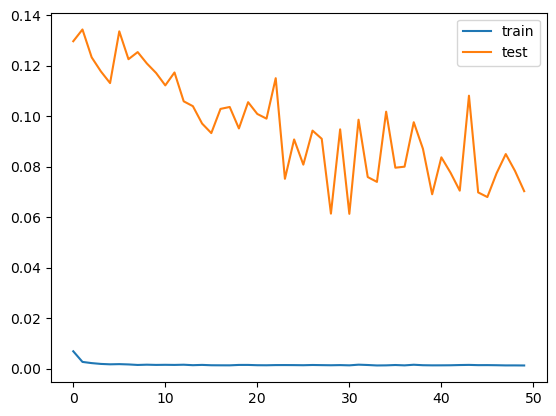

In [14]:
from matplotlib import pyplot as plt
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
# plt.title(f'Epochs={epoch_num}, Batch_size={batch_size},Ahead=400')
# plt.savefig(f'compare/{n}.png')
plt.legend()
plt.show()


In [15]:
dddf_test = ddf.iloc[5*2880:6*2880]
dddf_test

,power
date,
2015-10-06 00:00:00,0.68746
2015-10-06 00:00:30,0.72800
2015-10-06 00:01:00,0.71309
2015-10-06 00:01:30,0.69825
2015-10-06 00:02:00,0.68252
...,...
2015-10-06 23:57:30,0.09270
2015-10-06 23:58:00,0.08648
2015-10-06 23:58:30,0.08854


In [16]:
ddddf_t= []
for i in range(len(dddf_test)):
    ddddf_t.append(dddf_test.iloc[i,0])
ddddf_t
    

[0.68746,
 0.728,
 0.71309,
 0.69825,
 0.68252,
 0.69047,
 0.67625,
 0.671,
 0.6976,
 0.67295,
 0.63501,
 0.66718,
 0.65663,
 0.68215,
 0.72906,
 0.74436,
 0.73298,
 0.72747,
 0.73847,
 0.70842,
 0.72588,
 0.65577,
 0.70392,
 0.63512,
 0.65878,
 0.65215,
 0.67405,
 0.66271,
 0.68665,
 0.69695,
 0.67598,
 0.67886,
 0.68464,
 0.65966,
 0.7134,
 0.726,
 0.67905,
 0.75692,
 0.75098,
 0.74791,
 0.72611,
 0.75567,
 0.77255,
 0.78939,
 0.77447,
 0.85458,
 0.83936,
 0.81494,
 0.82221,
 0.85761,
 0.82366,
 0.8496,
 0.84461,
 0.85783,
 0.85417,
 0.86815,
 0.8329,
 0.86394,
 0.87596,
 0.85247,
 0.82905,
 0.84484,
 0.82899,
 0.82305,
 0.84435,
 0.83746,
 0.84378,
 0.84716,
 0.85118,
 0.82973,
 0.87737,
 0.83717,
 0.88963,
 0.87277,
 0.85819,
 0.83345,
 0.84271,
 0.87169,
 0.88524,
 0.91248,
 0.91741,
 0.94666,
 0.95184,
 0.92441,
 0.90464,
 0.88651,
 0.87977,
 0.89541,
 0.88915,
 0.89405,
 0.889,
 0.88357,
 0.86395,
 0.8145,
 0.82004,
 0.81908,
 0.81483,
 0.83655,
 0.86302,
 0.84923,
 0.85844,
 0.

In [17]:
test_X, test_y = split_sequence(ddddf_t, sw_width, n_features)

split_sequence:
X:
[[0.68746 0.728   0.71309 ... 0.66271 0.68665 0.69695]
 [0.728   0.71309 0.69825 ... 0.68665 0.69695 0.67598]
 [0.71309 0.69825 0.68252 ... 0.69695 0.67598 0.67886]
 ...
 [0.09913 0.10033 0.09662 ... 0.09039 0.0927  0.08648]
 [0.10033 0.09662 0.09461 ... 0.0927  0.08648 0.08854]
 [0.09662 0.09461 0.0978  ... 0.08648 0.08854 0.08421]]
y:
[0.67598 0.67886 0.68464 ... 0.08854 0.08421 0.08376]

X_shape:(2850, 30),y_shape:(2850,)

train_X:
[[[0.68746]
  [0.728  ]
  [0.71309]
  ...
  [0.66271]
  [0.68665]
  [0.69695]]

 [[0.728  ]
  [0.71309]
  [0.69825]
  ...
  [0.68665]
  [0.69695]
  [0.67598]]

 [[0.71309]
  [0.69825]
  [0.68252]
  ...
  [0.69695]
  [0.67598]
  [0.67886]]

 ...

 [[0.09913]
  [0.10033]
  [0.09662]
  ...
  [0.09039]
  [0.0927 ]
  [0.08648]]

 [[0.10033]
  [0.09662]
  [0.09461]
  ...
  [0.0927 ]
  [0.08648]
  [0.08854]]

 [[0.09662]
  [0.09461]
  [0.0978 ]
  ...
  [0.08648]
  [0.08854]
  [0.08421]]]
train_y:
[0.67598 0.67886 0.68464 ... 0.08854 0.08421 0.

In [18]:
y_pred_test = model.predict(test_X)
y_pred_test


90/90 [==============================] - 1s 4ms/step


array([[0.41762346],
       [0.4171971 ],
       [0.41604176],
       ...,
       [0.07338111],
       [0.07349021],
       [0.07277778]], dtype=float32)

预测与实际差异RMSE: [0.46751517 0.47023763 0.47570706 ... 0.21120398 0.21421299 0.2145283 ]


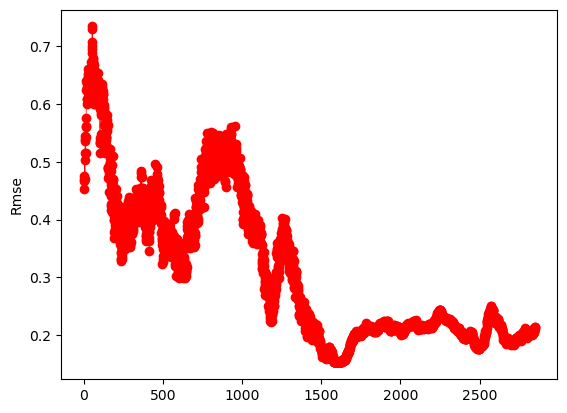

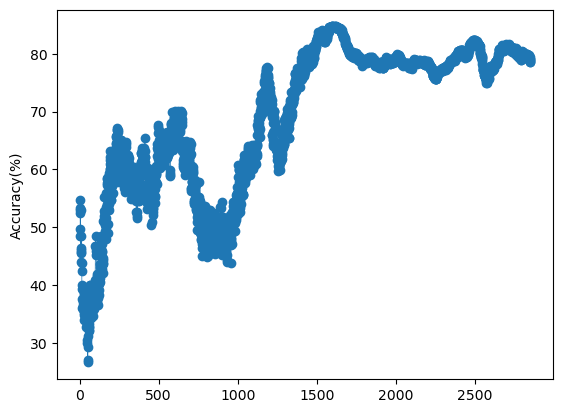

In [19]:
#模型评估
a = (sum(pow((y_pred_test - test_y),2))/y_pred_test.shape[0])**0.5
print('预测与实际差异RMSE:',a)
t = np.arange(len(a))
# plt.figure(figsize=(18,6))
plt.scatter(t,a,color = 'r')
plt.plot(t, a,"-",color='r', linewidth=0.5)
plt.ylabel('Rmse')

# plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
# plt.legend()
plt.show()
tt = [1 for i in range(2850)]
acc = (tt - a)*100
acc
plt.scatter(t,acc)
plt.plot(t, acc,"-", linewidth=0.5)
plt.ylabel('Accuracy(%)')
# plt.legend()
plt.show()
# print('预测与实际差异RMSE:',(sum(pow((y_test_predict - real_y),2))/y_test_predict.shape[0])**0.5)

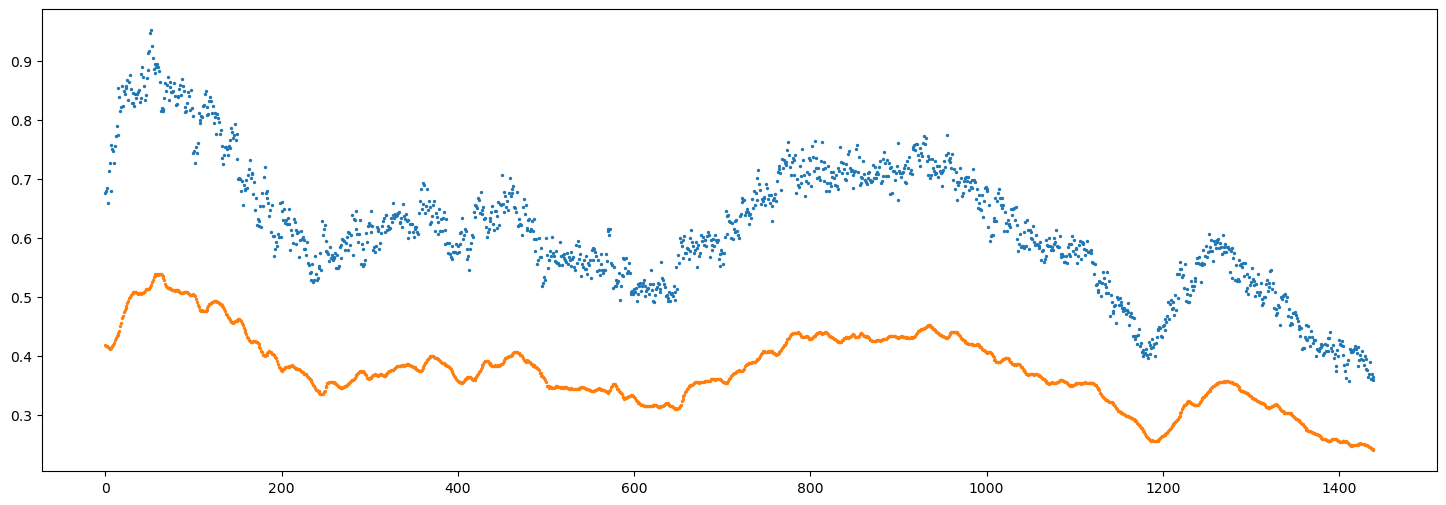

In [20]:
t = np.arange(1440)
plt.figure(figsize=(18,6))
# plt.plot(t, test_y,"rs-", linewidth=0.7, label='Real')
plt.scatter(t,test_y[:1440],s=2)
plt.scatter(t,y_pred_test[:1440],s=2)
# plt.plot(t, y_pred_test, 'go-', linewidth=0.5, label='Predict')
# plt.legend()
plt.show()